In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import seaborn as sns
import warnings

G = (const.G).value 
c = (const.c).value

In [2]:
#function to calculate fisco
def f_isco(m):
    return c**3 / (6.**(3./2.) * np.pi * G * m )

#function to calculate symmetric mass ratio

def v_sym(m1, m2):
    return m1 * m2 / (m1 + m2)**2

#function to get radius separation as soon as the binary enters the 
#detectors minimum frequency
def a_start(f_minimum, m):
    a = ( np.sqrt( G * m) / np.pi / f_minimum )**(2. / 3.)
    return a

#function to calculate the binary coalescence time from the moment it 
#enters the detector's frequency range with total mass and reduced mass
def tcoal(fmin, m, mu):
    r0 = a_start(f_minimum = fmin, m = m)
    t_coal = 5. / 256. * c**5 * r0**4 / G**3 / m**2 / mu
    return t_coal

#function to calculate the binary coalescence time from the moment it 
#enters the detector's frequency range with total mass and reduced mass
#but this takes m1  and m2 as inputs
def tcoal2(fmin, m11, m22):
    m = (m11 + m22)* const.M_sun.value
    mu = m11 * m22 * const.M_sun.value**2 / m
    r0 = a_start(f_minimum = fmin, m = m)
    t_coal = 5. / 256. * c**5 * r0**4 / G**3 / m**2 / mu
    return t_coal

#function to extract m1 and m2 from the chrip mass mc and the mass ratio q
def m1m2( mc, q):
    
    m2 = mc * (  q / (1 + q) **2 )**(-3. / 5.) * (1 + q )**(-1)
    m1 = q * m2
    
    return m1, m2

#return chirp mass given two masses
def chirp(m1, m2):
    return ( m1 * m2 )**(3. / 5.) / (m1 + m2)**(1. / 5.)

#function to calculate GW phase in the PN expension
def freq_phase( m, v, f, T, phi0, PN  ):
    psi0 = 2 * np.pi * f * T + phi0 - np.pi/4
    x = ( np.pi * G * m * f / c**3)**(1/3)
    
    if PN == 0 :

        return psi0 - 3. * x**(-5) / 128. / v * ( 1)

    elif PN == 1 :

        return psi0 - 3. * x**(-5) / 128. / v * ( 1
                                                +(3715. / 756. + 55. / 9. *v) * x**2 
                                                )
    elif PN == 1.5 :

        return psi0 - 3. * x**(-5) / 128. / v * ( 1
                                            +(3715. / 756. + 55. / 9. *v) * x**2 
                                             - 16. * np.pi * x**3
                                            )
    elif PN == 2 :

        return psi0 - 3. * x**(-5) / 128. / v * ( 1
                                                + (3715. / 756. + 55. / 9. *v) * x**2 
                                                 - 16. * np.pi * x**3
                                                 + (15293365. / 508032. + 27145. / 504. * v + 3085. / 72. * v**2) * x**4
                                                )

    
#Function to calculate GW phase (with dark matter) with a constant density X in g / cm^3
#This function should be equivalent to freq_phase at X = 0, PN =0 and 
#subtracted the constant phase at the end of the evolution (fisco)
def Phi(f,m1,m2,X,fmax):
    
    #constants in cgs
    G0 = 6.6743e-8
    c0 = 2.9979246e10
    Msun0 = 1.9884e33
    
    M = m1+m2
    fgrid = np.linspace(f,fmax,int(1e3))
    
    mc = (m1*m2)**(3./5.)/M**(1./5.)
    eta = (m1*m2)/M**2
    #coul_log = np.sqrt( m1 / m2)
    coul_log = 1.
    fdot = 96.*np.pi**(8./3.)*(G0*mc*Msun0/c0**3)**(5./3.)*fgrid**(11./3.)/5. + 12.*G0*eta*X * coul_log
    
    integral = np.trapz(fgrid/fdot,fgrid)
    
    return - integral * np.pi
    
#function to calculate A(f) 
def A_f( m, v, f, D):
    #getting reduced mass
    mu = m * v
    #getting chirp mass
    mc = mu**(3./5.) * m**(2./5.)
    #getting numerical factors
    A0 = (G / c**3 )**(5./6.) * c * np.sqrt( 2 / 3 / np.pi**(1./3.)) / D
    
    #returning amplitude as a function of frequency
    A = A0 * mc**(5/6) * (f)**(-7/6)
    
    return A
    

    
#computes the integral of x / (x^(11/3) +1) from a to b
def analytic_int(a,b):
    t1 = (-1)**(6/11) * np.log(1 - (-1)**(1/11) / a**(1/3))
    t1 -= (-1)**(1/11) * np.log(1 + (-1)**(2/11) / a**(1/3))
    t1 -= (-1)**(7/11) * np.log(1 - (-1)**(3/11) / a**(1/3))
    t1 += (-1)**(2/11) * np.log(1 + (-1)**(4/11) / a**(1/3))
    t1 += (-1)**(8/11) * np.log(1 - (-1)**(5/11) / a**(1/3))
    t1 -= (-1)**(3/11) * np.log(1 + (-1)**(6/11) / a**(1/3))
    t1 -= (-1)**(9/11) * np.log(1 - (-1)**(7/11) / a**(1/3))
    t1 += (-1)**(4/11) * np.log(1 + (-1)**(8/11) / a**(1/3))
    t1 += (-1)**(10/11) * np.log(1 - (-1)**(9/11) / a**(1/3))
    t1 -= (-1)**(5/11) * np.log(1 + (-1)**(10/11) / a**(1/3))
    
    t2 = (-1)**(6/11) * np.log(1 - (-1)**(1/11) / b**(1/3))
    t2 -= (-1)**(1/11) * np.log(1 + (-1)**(2/11) / b**(1/3))
    t2 -= (-1)**(7/11) * np.log(1 - (-1)**(3/11) / b**(1/3))
    t2 += (-1)**(2/11) * np.log(1 + (-1)**(4/11) / b**(1/3))
    t2 += (-1)**(8/11) * np.log(1 - (-1)**(5/11) / b**(1/3))
    t2 -= (-1)**(3/11) * np.log(1 + (-1)**(6/11) / b**(1/3))
    t2 -= (-1)**(9/11) * np.log(1 - (-1)**(7/11) / b**(1/3))
    t2 += (-1)**(4/11) * np.log(1 + (-1)**(8/11) / b**(1/3))
    t2 += (-1)**(10/11) * np.log(1 - (-1)**(9/11) / b**(1/3))
    t2 -= (-1)**(5/11) * np.log(1 + (-1)**(10/11) / b**(1/3))
    
    t3 = np.log((b**(1/3) + (b/a)**(1/3))/(1 + b**(1/3)))
    
    return  np.real( 3/11 * (t1 - t2 + t3) )


#takes f in hz, m1 and m2 in kg, X in 
def Phi_analytic(f,m1,m2,X,fmax):
        
    #constants in cgs
    G0 = 6.6743e-8
    c0 = 2.9979246e10
    Msun0 = 1.9884e33
    
    M = m1+m2
    
    mc = (m1*m2)**(3./5.)/M**(1./5.)
    #coul_log = np.sqrt( m1 / m2)
    coul_log = 1.
    
    A = 12. * G0 * (m1*m2)/M**2  * X * coul_log
    factor = ( 96. * np.pi**(8. / 3.) / ( 5. * A ) * ( G0*mc*Msun0/c0**3 )**(5. / 3. )  )**(3. / 11. )

    integral = ( factor**2 * A)**(-1) * analytic_int(f * factor , fmax * factor)
    
    return - integral * np.pi

#extract m1 and m2 when you're given chirp mass mc and total mass m
def m1m2_cm(mc, m):
    
    m1 = 0.5 *( m + np.sqrt( -4*mc**(5/3) * m**(1/3) + m**2 ) )
    m2 = 0.5 *( m - np.sqrt( -4*mc**(5/3) * m**(1/3) + m**2 ) ) 
    
    return max(m2,m1) , min(m2,m1)

def m_red(m1,m2):
    return m1 * m2 / (m1 + m2)

#extract m1 and m2 when you're given chirp mass mc and reduced mass m
def m1m2_red(mc, m):
    
    m1 = 0.5 *( mc**(5/2)/m**(3/2) + np.sqrt( -4*mc**(5/2) * m**(5/2) + mc**5 ) / m**(3/2) )
    m2 = ( 4*m**(7/2)*mc**(5/2) 
          - 4*m**(7/2)*np.sqrt(-4*mc**(5/2) * m**(5/2) + mc**5)
          - 4*m*mc**(5/2)*np.sqrt(-4*mc**(5/2) * m**(5/2) + mc**5)
          + mc**5 * np.sqrt(mc**5 - 4 * m**(5/2)*mc**(5/2))/m**(3/2)
          - (mc**5 - 4 * m**(5/2)*mc**(5/2))**(3/2)/m**(3/2) 
         ) / (8*m**5) 
    
    return max(m2,m1) , min(m2,m1)


#extract m1 and m2 when you're given chirp mass M and symmetric mass ratio m
def m1m2_sym(M, m):
    
    m1 = (M**5 / m**3 
          - 5 * M**5 / m**2 
          + 5* M**5 / m
          - np.sqrt( -M**10 * (-1 + 4*m) * (1 - 3*m + m**2)**2) / m**3
         )**(1/5) / 2**(1/5)
    
    
    m2 = (M**5 * m1 /2 
          -5 * M**5 * m * m1 / 2
          +7 * M**5 * m**2 * m1 / 2
          - M**5 * m**3 * m1 
          + np.sqrt( - M**10 * (-1 + 4*m) * (1 - 3*m + m**2)**2) * m1 / 2
         
         )/ (M**5 * m * (1 - 3*m + m**2))
    
    return max(m2,m1) , min(m2,m1)

# m1m2_sym(M = chirp(mass1,mass2), m = v_sym(mass1, mass2) )
# m1m2_cm(mc =  chirp(mass1,mass2), m = mass1 + mass2)
# m1m2_red(mc = chirp(mass1,mass2), m= m_red(mass1,mass2))

In [3]:
# m1 = 5.7
# m2 = 1.5

# mc = ( m1 * m2 )**(3. / 5.) / (m1 + m2)**(1. / 5.)
# print( 'Chirp mass: ', mc)

# mtot = m1 + m2
# print( 'Total mass: ', mtot)

# msym = ( m1 * m2) / mtot**2
# print( 'Sym   mass: ', msym)

## Some initial parameters for the search

In [10]:
#masses of the binary
mass1 = 10.
mass2 = 6.

#dark matter density
X = 1e5 # set to 0 to turn off dynamical friction, X = rho_dm*xi*logLambda this is in 

#luminosity distance
lum_dist = 20

#inclination angle
theta = np.pi/3

In [11]:
 v_sym(10, 6)

0.234375

In [12]:
# First set up logging and some output directories and labels
outdir = 'Outdic_full'
label = 'Week6_hist'



sampling_frequency = 2048.0
minimum_frequency = 20
duration = int( tcoal2(fmin = 20, m11 = mass1, m22 = mass2) +1 )
duration = 56.

bilby.core.utils.setup_logger(outdir=outdir, label=label)

## Defining the frequency domain waveform class

In [13]:
def h_newt(f, chirp_mass,  symmetric_mass_ratio, luminosity_distance, chi_1, chi_2, DM_density, theta, geocent_time, ra, dec, psi):
    '''Function to calculate GW waveform 
        f is the given frequency
        M_chirp is the chirp mass
        q is the mass ratio m1/m2
        luminosity distance is the distance in Mpc
        X is the local dark matter density in g/cm^3
        theta is the inclination of the binary wrt the observer
    '''
    #mass conversions
#     m11, m22 = m1m2_cm(mc =  chirp_mass, m = total_mass)
#     m11, m22 = m1m2( mc = chirp_mass, q = 1 / mass_ratio) 
    m11, m22 = m1m2_sym(M = chirp_mass, m = symmetric_mass_ratio )
    
    
    mass_1 = (m11 * const.M_sun).value
    mass_2 = (m22 * const.M_sun).value
    
    #distance in Mpc
    D = (1e6 * const.pc).value * luminosity_distance
    
    #total mass and reduced mass
    m = mass_1 + mass_2
    mu = mass_1 * mass_2 / m
    
    #frequenct calculations
    fmin = (20 * u.Hz).value
    fisco = f_isco(m)
    fmax = min(fisco,2000.) # ending frequency in Hz
    
    #mass rescaling factor
    v = v_sym(m1 = mass_1, m2 = mass_2)
    
    #time to coalescence
    T = tcoal(fmin = fmin, m = m, mu = mu)
    
    
    #PN order
    PN = 0
    
    phi_0 = Phi_analytic(f = f ,m1 = m11,m2 = m22, X = DM_density,fmax = fmax )
    
    
    #phase calcualtion without dark matter
#     psi_SPA = freq_phase( m =m, v=v, f=f, T=T, phi0 = 0.0, PN = PN  ) #old function that uses the PN order

    #phase calculation with dark matter
    psi_SPA = 2 * np.pi * f * T  - np.pi/4 + phi_0

    #amplitude
    A_SPA = A_f( m = m, v = v, f = f + 1e-4, D = D)

    
    #polarization calculation
    plus = A_SPA * np.exp( 1j * psi_SPA  ) * ( 1 + np.cos(theta)**2) / 2.
    cross = A_SPA * np.exp( 1j * ( psi_SPA + np.pi /2. )  ) * np.cos(theta)
    
    return {'plus': plus, 'cross': cross}

## Injection parameters

In [14]:
#set injection parameters to the previously defined constants
injection_parameters = dict(
                            chirp_mass=  chirp(mass1,mass2) ,
                            symmetric_mass_ratio = v_sym(mass1, mass2) , 
                            luminosity_distance= lum_dist,
                            chi_1 = 0.0,
                            chi_2 = 0.0,
                            DM_density=X,
                            theta = theta,
                            geocent_time=1126259642,
                            ra=0, 
                            dec=0, 
                            psi=0)

In [15]:
m1m2_sym(M = chirp(mass1,mass2), m = v_sym(mass1,mass2) )

(9.999999999999972, 5.999999999999987)

## Waveform generator

In [16]:
# Passing our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, 
    sampling_frequency=sampling_frequency ,
    frequency_domain_source_model=h_newt
)

15:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.h_newt
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


## Setting up the interferometers and frequency band

In [17]:
# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
for interferometer in ifos:
    interferometer.minimum_frequency = 20

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, 
    duration=duration,
    start_time=injection_parameters['geocent_time'] 
)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)



/tmp/ipykernel_2344765/2247937962.py:115: RuntimeWarning: divide by zero encountered in true_divide
  t1 = (-1)**(6/11) * np.log(1 - (-1)**(1/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:116: RuntimeWarning: divide by zero encountered in true_divide
  t1 -= (-1)**(1/11) * np.log(1 + (-1)**(2/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:116: RuntimeWarning: invalid value encountered in subtract
  t1 -= (-1)**(1/11) * np.log(1 + (-1)**(2/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:117: RuntimeWarning: divide by zero encountered in true_divide
  t1 -= (-1)**(7/11) * np.log(1 - (-1)**(3/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:117: RuntimeWarning: invalid value encountered in subtract
  t1 -= (-1)**(7/11) * np.log(1 - (-1)**(3/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:118: RuntimeWarning: divide by zero encountered in true_divide
  t1 += (-1)**(2/11) * np.log(1 + (-1)**(4/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:119: RuntimeWarnin

[{'plus': array([            nan           +nanj, -4.10660293e-18-8.21974352e-20j,
         -7.75657219e-19-1.66367840e-18j, ...,
         -5.03946992e-24+1.04596995e-23j, -1.15659433e-23+1.01244273e-24j,
         -6.77983670e-24-9.42467056e-24j]),
  'cross': array([            nan           +nanj,  6.57579482e-20-3.28528235e-18j,
          1.33094272e-18-6.20525775e-19j, ...,
         -8.36775960e-24-4.03157594e-24j, -8.09954184e-25-9.25275467e-24j,
          7.53973645e-24-5.42386936e-24j])},
 {'plus': array([            nan           +nanj, -4.10660293e-18-8.21974352e-20j,
         -7.75657219e-19-1.66367840e-18j, ...,
         -5.03946992e-24+1.04596995e-23j, -1.15659433e-23+1.01244273e-24j,
         -6.77983670e-24-9.42467056e-24j]),
  'cross': array([            nan           +nanj,  6.57579482e-20-3.28528235e-18j,
          1.33094272e-18-6.20525775e-19j, ...,
         -8.36775960e-24-4.03157594e-24j, -8.09954184e-25-9.25275467e-24j,
          7.53973645e-24-5.42386936e-24j])}]

Text(0.5, 0, 'Frequency (hz)')

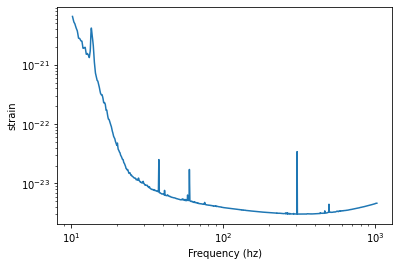

In [18]:
plt.plot( ifos[0].frequency_array, ifos[0].amplitude_spectral_density_array ) 
plt.yscale('log')
plt.xscale('log')
plt.ylabel('strain') 
plt.xlabel('Frequency (hz)')

## Set up antenna response functions

In [19]:
def h_variable(interf, injection_params):
    F_plus0 = interf[0].antenna_response(ra = injection_params['ra'],
                         dec = injection_params['dec'], 
                         time = injection_params['geocent_time'], 
                         psi = injection_params['psi'], 
                         mode = 'plus')


    F_cross0 = interf[0].antenna_response(ra = injection_params['ra'],
                             dec = injection_params['dec'], 
                             time = injection_params['geocent_time'], 
                             psi = injection_params['psi'], 
                             mode = 'cross')
    
    
    h_strain = h_newt(interf.frequency_array,
        chirp_mass=  injection_params['chirp_mass'] ,
        symmetric_mass_ratio =  injection_params['symmetric_mass_ratio'] , 
        luminosity_distance=  injection_params['luminosity_distance'],
        chi_1 =  injection_params['chi_1'],
        chi_2 =  injection_params['chi_2'],
        DM_density= injection_params['DM_density'],
        theta =  injection_params['theta'],
        geocent_time= injection_params['geocent_time'],
        ra= injection_params['ra'], 
        dec= injection_params['dec'], 
        psi= injection_params['psi']) 
    
    return h_strain['plus'] * F_plus0 + h_strain['cross'] * F_cross0
    

Text(0, 0.5, 'h(f)')

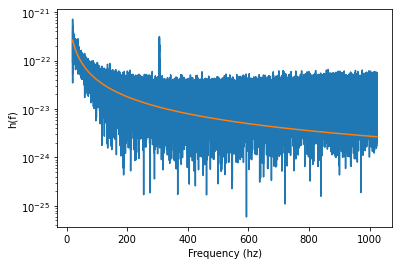

In [17]:
F_plus = ifos[0].antenna_response(ra = injection_parameters['ra'],
                         dec = injection_parameters['dec'], 
                         time = injection_parameters['geocent_time'], 
                         psi = injection_parameters['psi'], 
                         mode = 'plus')


F_cross = ifos[0].antenna_response(ra = injection_parameters['ra'],
                         dec = injection_parameters['dec'], 
                         time = injection_parameters['geocent_time'], 
                         psi = injection_parameters['psi'], 
                         mode = 'cross')

plt.plot(ifos[0].frequency_array[ifos[0].frequency_mask],
         np.abs(ifos[0].frequency_domain_strain)[ifos[0].frequency_mask]
        )



plt.plot( ifos[0].frequency_array[ifos[0].frequency_mask]
    , np.abs(F_plus * waveform_generator.frequency_domain_strain()['plus'] 
+ F_cross * waveform_generator.frequency_domain_strain()['cross'])[ifos[0].frequency_mask] )

plt.yscale('log')

plt.xlabel('Frequency (hz)')
plt.ylabel('h(f)')

## Computing h(f) template and defining inner product

# $(A|B) = 4 Re \int_{f_{min}}^{f_{max}} \frac{ A^{*}(f) B(f) }{S_n(f)}$

In [20]:
def scalar_product( A, B, f, mask, Sn ):
    
    integrand = 4 * np.conj(A[mask]) * B[mask] / Sn[mask]
    
    integral = np.trapz( np.real( integrand ), f[mask])

    return integral

In [30]:
h_newt(ifos[0].frequency_array[ifos[0].frequency_mask],
        chirp_mass=  chirp(mass1,mass2) ,
        symmetric_mass_ratio =v_sym(mass1, mass2), 
        luminosity_distance= lum_dist,
        chi_1 = 0.0,
        chi_2 = 0.0,
        DM_density=X,
        theta = theta,
        geocent_time=1126259642,
        ra=0, 
        dec=0, 
        psi=0)['plus'] * F_plus

array([-2.13550828e-23+7.87563709e-24j, -1.94744460e-23+1.17359909e-23j,
       -1.66842361e-23+1.54126344e-23j, ...,
       -2.33433766e-26+2.29524768e-25j,  1.33800167e-25+1.87941166e-25j,
        2.24514795e-25+5.30594740e-26j])

In [22]:
h_template = (F_plus * waveform_generator.frequency_domain_strain()['plus'] 
              + F_cross * waveform_generator.frequency_domain_strain()['cross'])
h_template[ifos[0].frequency_mask]

array([-1.12263389e-22-2.38625615e-22j, -1.54942731e-22-2.13057111e-22j,
       -1.94591937e-22-1.77173137e-22j, ...,
       -2.67274273e-24-3.99273158e-26j, -2.03560059e-24+1.73239355e-24j,
       -3.87949549e-25+2.64462882e-24j])

In [41]:
scalar_product(A = waveform_generator.frequency_domain_strain()['plus']  , 
               B = waveform_generator.frequency_domain_strain()['plus'] ,
               f = ifos[0].frequency_array,
               mask = ifos[0].frequency_mask, 
               Sn = ifos[0].power_spectral_density_array)

366257.58489382744

In [21]:
injection_parameters

{'chirp_mass': 6.699875826622859,
 'symmetric_mass_ratio': 0.234375,
 'luminosity_distance': 20,
 'chi_1': 0.0,
 'chi_2': 0.0,
 'DM_density': 100000.0,
 'theta': 1.0471975511965976,
 'geocent_time': 1126259642,
 'ra': 0,
 'dec': 0,
 'psi': 0}

### Bilby notifications supressor

In [22]:
#Bilby notifications
import logging

# Store the original logging level state (the original spams console everytime
# there's a waveform computation)
original_logging_level = logging.getLogger("bilby").getEffectiveLevel()


In [23]:
# Set Bilby logger's logging level to WARNING (only notify console if a problem arises)
logging.getLogger("bilby").setLevel(logging.WARNING)

In [24]:
# Reset the logging level back to its original value (original Bibly notifications)
logging.getLogger("bilby").setLevel(original_logging_level)

In [25]:
#Setting the lower and upper bounds of the sampled mass ratio array
sym_mass_ratio_array = np.linspace(0.2,0.25,100)

#Setting the lower and upper bounds for the sampled DM density array
rho_array= np.linspace(1e4,5e5,100)
# d_array = np.linspace(5,60,200)

#putting the uniform samples in an array for x-y likelihood plots
y_samples = rho_array
x_samples = sym_mass_ratio_array


#create storage array for data
data_matrix = np.zeros((len(y_samples),len(x_samples)))                 

In [26]:
#run the loop over all variables to compute likelihood

for i in range(len(x_samples)):
    for j in range(len(y_samples)):
        #set injection parameters to the previously defined constants
        
        
        #creating an injection params dictionary
        injection_parameters_tmp = dict(
                                    chirp_mass=  chirp(mass1,mass2) ,
                                    symmetric_mass_ratio = x_samples[i] , 
#                                     luminosity_distance = y_samples[j],
                                    luminosity_distance= lum_dist,
                                    chi_1 = 0.0,
                                    chi_2 = 0.0,
#                                     DM_density=X,
                                    DM_density = y_samples[j],
                                    theta = theta,
                                    geocent_time=1126259642,
                                    ra=0, 
                                    dec=0, 
                                    psi=0)
        

        #setting up a detector
        ifos2 = bilby.gw.detector.InterferometerList(['H1', 'L1'])
        for interferometer in ifos2:
            interferometer.minimum_frequency = 20

        ifos2.set_strain_data_from_power_spectral_densities(
            sampling_frequency=sampling_frequency, 
            duration=duration,
            start_time=injection_parameters_tmp['geocent_time'] 
        )

        # Passing our source function to the WaveformGenerator
        waveform_generator2 = bilby.gw.waveform_generator.WaveformGenerator(
            duration=duration, 
            sampling_frequency=sampling_frequency ,
            frequency_domain_source_model=h_newt
        )


        # Inject the signal

        ifos2.inject_signal(waveform_generator=waveform_generator2,
                           parameters=injection_parameters_tmp)

        #sampled params tempalte h
        h_f = h_variable(ifos2, injection_parameters_tmp)

        #actual signal with real params s
        h_template = h_variable(ifos, injection_parameters)

        #computing (s|h)
        sh = scalar_product(A = h_template  , 
                       B = h_f ,
                       f = ifos2[0].frequency_array,
                       mask = ifos2[0].frequency_mask, 
                       Sn = ifos2[0].power_spectral_density_array)

        #computing (h|h)
        hh = scalar_product(A = h_template  , 
                       B = h_template ,
                       f = ifos2[0].frequency_array,
                       mask = ifos2[0].frequency_mask, 
                       Sn = ifos2[0].power_spectral_density_array)
     
        #storing output as the exponent of the likelihood (s|h) - (h|h)/2 (ignoring noise)
        data_matrix[len(y_samples)-1 - j][i] = sh - hh / 2
        
        #printing progress bar
        print(f"Current X Index: {j+1 + i * len(x_samples)}" + "/ " + str(len(x_samples) * len(y_samples)) , end='\r')
        
        
        
        

/tmp/ipykernel_2344765/2247937962.py:115: RuntimeWarning: divide by zero encountered in true_divide
  t1 = (-1)**(6/11) * np.log(1 - (-1)**(1/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:116: RuntimeWarning: divide by zero encountered in true_divide
  t1 -= (-1)**(1/11) * np.log(1 + (-1)**(2/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:116: RuntimeWarning: invalid value encountered in subtract
  t1 -= (-1)**(1/11) * np.log(1 + (-1)**(2/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:117: RuntimeWarning: divide by zero encountered in true_divide
  t1 -= (-1)**(7/11) * np.log(1 - (-1)**(3/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:117: RuntimeWarning: invalid value encountered in subtract
  t1 -= (-1)**(7/11) * np.log(1 - (-1)**(3/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:118: RuntimeWarning: divide by zero encountered in true_divide
  t1 += (-1)**(2/11) * np.log(1 + (-1)**(4/11) / a**(1/3))
/tmp/ipykernel_2344765/2247937962.py:119: RuntimeWarnin

In [27]:
data_matrix

array([[-548414.80205632, -534847.51374518, -521055.97144551, ...,
         114745.28566459,  109481.34571023,  104048.57549381],
       [-548512.60335323, -534922.92746148, -521109.02029777, ...,
         115143.39082382,  109868.56149702,  104424.79913352],
       [-548610.50522617, -534997.99084066, -521161.26810646, ...,
         115540.00606229,  110253.78575404,  104798.53130667],
       ...,
       [-458863.57325844, -441617.34170363, -424264.41727571, ...,
          89724.77772225,   81242.22204557,   72613.16567216],
       [-457250.47073941, -440050.35567131, -422745.45490607, ...,
          87012.84766358,   78541.74790616,   69925.48784837],
       [-455736.1535405 , -438580.83317273, -421322.51007998, ...,
          84493.93570566,   76035.18203767,   67432.51991601]])

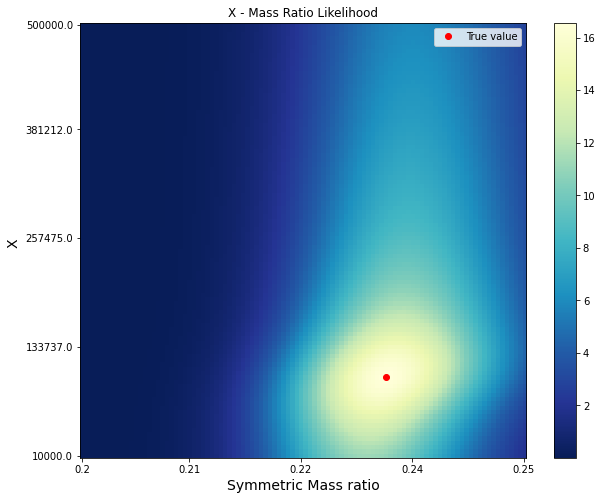

In [45]:
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors



# Sample data matrix A (contains data about computed likelihoods)
#uncomment this line if you just want to see exponents
#A =  data_matrix / 1e5  

# plotting exp( (s|h) - (h|h)/2   ) with an aribitraty normalization of 1e5 for display purposes
A = np.exp(data_matrix / 1e5)

# Sample x and y vectors (replace these with your own data)
x = x_samples
#y is flipped when displayed, so flip it again to display ascending order
y = np.flip(y_samples)



# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,8))

# Display matrix A as a heatmap
cax = ax.imshow(A, cmap='YlGnBu_r', aspect='auto')



# Set custom tick positions and labels for the x and y axes (since it's 100 elements, set
# ticks to every 25 elements)
ax.set_xticks(np.array([ 0, 24, 49, 74, 99]))
ax.set_xticklabels(np.round(x[np.array([ 0, 24, 49, 74, 99])], 2))

#yticks
ax.set_yticks(np.array([ 0, 24, 49, 74, 99]))
ax.set_yticklabels(np.round(y[np.array([ 0, 24, 49, 74, 99])], 0))

# Add colorbar
cbar = fig.colorbar(cax)

# Set labels for x and y axes
plt.xlabel('Symmetric Mass ratio', fontsize = 14)
plt.ylabel('X ', fontsize = 14)

# Set the title of the plot (optional)
plt.title('X - Mass Ratio Likelihood')
ax.plot(np.abs(x - v_sym(mass1, mass2)).argmin(), np.abs(y -X).argmin(), 'ro', lw = 0.5, label = 'True value')
plt.legend()


# Show the plot
plt.show()